In [1]:
# https://deeplearningcourses.com/c/unsupervised-deep-learning-in-python
# https://www.udemy.com/unsupervised-deep-learning-in-python
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

In [2]:
def relu(x):
    return x * (x > 0)


def error_rate(p, t):
    return np.mean(p != t)


def getKaggleMNIST():
    # MNIST data:
    # column 0 is labels
    # column 1-785 is data, with values 0 .. 255
    # total size of CSV: (42000, 1, 28, 28)
    train = pd.read_csv('us_data/train.csv').as_matrix().astype(np.float32)
    train = shuffle(train)

    Xtrain = train[:-1000,1:] / 255
    Ytrain = train[:-1000,0].astype(np.int32)

    Xtest  = train[-1000:,1:] / 255
    Ytest  = train[-1000:,0].astype(np.int32)
    return Xtrain, Ytrain, Xtest, Ytest


def init_weights(shape):
    return np.random.randn(*shape) / np.sqrt(sum(shape))

In [3]:
class AutoEncoder(object):
    def __init__(self, M, an_id):
        self.M = M
        self.id = an_id

    def fit(self, X, learning_rate=0.5, mu=0.99, epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = N // batch_sz

        W0 = init_weights((D, self.M))
        self.W = theano.shared(W0, 'W_%s' % self.id)
        self.bh = theano.shared(np.zeros(self.M), 'bh_%s' % self.id)
        self.bo = theano.shared(np.zeros(D), 'bo_%s' % self.id)
        self.params = [self.W, self.bh, self.bo]
        self.forward_params = [self.W, self.bh]

        # TODO: technically these should be reset before doing backprop
        self.dW = theano.shared(np.zeros(W0.shape), 'dW_%s' % self.id)
        self.dbh = theano.shared(np.zeros(self.M), 'dbh_%s' % self.id)
        self.dbo = theano.shared(np.zeros(D), 'dbo_%s' % self.id)
        self.dparams = [self.dW, self.dbh, self.dbo]
        self.forward_dparams = [self.dW, self.dbh]

        X_in = T.matrix('X_%s' % self.id)
        X_hat = self.forward_output(X_in)

        # attach it to the object so it can be used later
        # must be sigmoidal because the output is also a sigmoid
        H = T.nnet.sigmoid(X_in.dot(self.W) + self.bh)
        self.hidden_op = theano.function(
            inputs=[X_in],
            outputs=H,
        )

        # save this for later so we can call it to
        # create reconstructions of input
        self.predict = theano.function(
            inputs=[X_in],
            outputs=X_hat,
        )

        cost = -(X_in * T.log(X_hat) + (1 - X_in) * T.log(1 - X_hat)).flatten().mean()
        cost_op = theano.function(
            inputs=[X_in],
            outputs=cost,
        )

        updates = [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]
        train_op = theano.function(
            inputs=[X_in],
            updates=updates,
        )

        costs = []
        print("training autoencoder: %s" % self.id)
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(batch)
                the_cost = cost_op(batch) # technically we could also get the cost for Xtest here
                if j % 10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", the_cost)
                costs.append(the_cost)
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward_hidden(self, X):
        Z = T.nnet.sigmoid(X.dot(self.W) + self.bh)
        return Z

    def forward_output(self, X):
        Z = self.forward_hidden(X)
        Y = T.nnet.sigmoid(Z.dot(self.W.T) + self.bo)
        return Y

    @staticmethod
    def createFromArrays(W, bh, bo, an_id):
        ae = AutoEncoder(W.shape[1], an_id)
        ae.W = theano.shared(W, 'W_%s' % ae.id)
        ae.bh = theano.shared(bh, 'bh_%s' % ae.id)
        ae.bo = theano.shared(bo, 'bo_%s' % ae.id)
        ae.params = [ae.W, ae.bh, ae.bo]
        ae.forward_params = [ae.W, ae.bh]
        return ae

In [4]:
class DNN(object):
    def __init__(self, hidden_layer_sizes, UnsupervisedModel=AutoEncoder):
        self.hidden_layers = []
        count = 0
        for M in hidden_layer_sizes:
            ae = UnsupervisedModel(M, count)
            self.hidden_layers.append(ae)
            count += 1


    def fit(self, X, Y, Xtest, Ytest, pretrain=True, learning_rate=0.01, mu=0.99, reg=0.1, epochs=1, batch_sz=100):
        # greedy layer-wise training of autoencoders
        pretrain_epochs = 1
        if not pretrain:
            pretrain_epochs = 0

        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=pretrain_epochs)

            # create current_input for the next layer
            current_input = ae.hidden_op(current_input)

        # initialize logistic regression layer
        N = len(Y)
        K = len(set(Y))
        W0 = init_weights((self.hidden_layers[-1].M, K))
        self.W = theano.shared(W0, "W_logreg")
        self.b = theano.shared(np.zeros(K), "b_logreg")

        self.params = [self.W, self.b]
        for ae in self.hidden_layers:
            self.params += ae.forward_params

        # for momentum
        self.dW = theano.shared(np.zeros(W0.shape), "dW_logreg")
        self.db = theano.shared(np.zeros(K), "db_logreg")
        self.dparams = [self.dW, self.db]
        for ae in self.hidden_layers:
            self.dparams += ae.forward_dparams

        X_in = T.matrix('X_in')
        targets = T.ivector('Targets')
        pY = self.forward(X_in)

        # squared_magnitude = [(p*p).sum() for p in self.params]
        # reg_cost = T.sum(squared_magnitude)
        cost = -T.mean( T.log(pY[T.arange(pY.shape[0]), targets]) ) #+ reg*reg_cost
        prediction = self.predict(X_in)
        cost_predict_op = theano.function(
            inputs=[X_in, targets],
            outputs=[cost, prediction],
        )

        updates = [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]
        # updates = [(p, p - learning_rate*T.grad(cost, p)) for p in self.params]
        train_op = theano.function(
            inputs=[X_in, targets],
            updates=updates,
        )

        n_batches = N // batch_sz
        costs = []
        print("supervised training...")
        for i in range(epochs):
            print("epoch:", i)
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(Xbatch, Ybatch)
                the_cost, the_prediction = cost_predict_op(Xtest, Ytest)
                error = error_rate(the_prediction, Ytest)
                print("j / n_batches:", j, "/", n_batches, "cost:", the_cost, "error:", error)
                costs.append(the_cost)
        plt.plot(costs)
        plt.show()

    def predict(self, X):
        return T.argmax(self.forward(X), axis=1)

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        # logistic layer
        Y = T.nnet.softmax(T.dot(current_input, self.W) + self.b)
        return Y

training autoencoder: 0
training autoencoder: 1
training autoencoder: 2
supervised training...
epoch: 0
j / n_batches: 0 / 410 cost: 2.327398389025256 error: 0.898
j / n_batches: 1 / 410 cost: 2.3219998083337874 error: 0.898
j / n_batches: 2 / 410 cost: 2.316296973990106 error: 0.898
j / n_batches: 3 / 410 cost: 2.311890186523443 error: 0.898
j / n_batches: 4 / 410 cost: 2.311997520194406 error: 0.904
j / n_batches: 5 / 410 cost: 2.3172536092274556 error: 0.886
j / n_batches: 6 / 410 cost: 2.324231665939777 error: 0.886
j / n_batches: 7 / 410 cost: 2.3305974221414756 error: 0.886
j / n_batches: 8 / 410 cost: 2.3355335925767498 error: 0.886
j / n_batches: 9 / 410 cost: 2.3335841368346912 error: 0.886
j / n_batches: 10 / 410 cost: 2.328818750493554 error: 0.886
j / n_batches: 11 / 410 cost: 2.333500953403082 error: 0.913
j / n_batches: 12 / 410 cost: 2.333985399297386 error: 0.913
j / n_batches: 13 / 410 cost: 2.3339698315891324 error: 0.904
j / n_batches: 14 / 410 cost: 2.33904835231453

j / n_batches: 132 / 410 cost: 2.3344240955901516 error: 0.842
j / n_batches: 133 / 410 cost: 2.3371499129932114 error: 0.898
j / n_batches: 134 / 410 cost: 2.3400370787035474 error: 0.898
j / n_batches: 135 / 410 cost: 2.343312868525998 error: 0.898
j / n_batches: 136 / 410 cost: 2.3464367223209024 error: 0.898
j / n_batches: 137 / 410 cost: 2.3494496311780435 error: 0.898
j / n_batches: 138 / 410 cost: 2.351666790340361 error: 0.898
j / n_batches: 139 / 410 cost: 2.3532342529571055 error: 0.898
j / n_batches: 140 / 410 cost: 2.3538998036893015 error: 0.898
j / n_batches: 141 / 410 cost: 2.3539817441557997 error: 0.898
j / n_batches: 142 / 410 cost: 2.3531830852378492 error: 0.898
j / n_batches: 143 / 410 cost: 2.351960551376878 error: 0.898
j / n_batches: 144 / 410 cost: 2.3505502433169707 error: 0.898
j / n_batches: 145 / 410 cost: 2.3490556960690334 error: 0.898
j / n_batches: 146 / 410 cost: 2.3470123535019316 error: 0.898
j / n_batches: 147 / 410 cost: 2.344580916872059 error: 0.

j / n_batches: 264 / 410 cost: 2.305643746412002 error: 0.913
j / n_batches: 265 / 410 cost: 2.3054813287979297 error: 0.913
j / n_batches: 266 / 410 cost: 2.3053481547268766 error: 0.913
j / n_batches: 267 / 410 cost: 2.3052125360872098 error: 0.913
j / n_batches: 268 / 410 cost: 2.3050985699324147 error: 0.913
j / n_batches: 269 / 410 cost: 2.305005803768929 error: 0.913
j / n_batches: 270 / 410 cost: 2.3049349162263018 error: 0.913
j / n_batches: 271 / 410 cost: 2.304861835675777 error: 0.913
j / n_batches: 272 / 410 cost: 2.3047938638625967 error: 0.913
j / n_batches: 273 / 410 cost: 2.3047210743618276 error: 0.913
j / n_batches: 274 / 410 cost: 2.3046934115401787 error: 0.913
j / n_batches: 275 / 410 cost: 2.304680329740745 error: 0.886
j / n_batches: 276 / 410 cost: 2.3046828929356287 error: 0.886
j / n_batches: 277 / 410 cost: 2.304702664331714 error: 0.886
j / n_batches: 278 / 410 cost: 2.3047430775677045 error: 0.886
j / n_batches: 279 / 410 cost: 2.304785793216629 error: 0.88

j / n_batches: 397 / 410 cost: 2.306425904988754 error: 0.883
j / n_batches: 398 / 410 cost: 2.3065453442113326 error: 0.883
j / n_batches: 399 / 410 cost: 2.3066748034424 error: 0.902
j / n_batches: 400 / 410 cost: 2.3067934707927864 error: 0.902
j / n_batches: 401 / 410 cost: 2.3069011602418894 error: 0.902
j / n_batches: 402 / 410 cost: 2.307022244599623 error: 0.902
j / n_batches: 403 / 410 cost: 2.3071320821671857 error: 0.902
j / n_batches: 404 / 410 cost: 2.307237781512527 error: 0.902
j / n_batches: 405 / 410 cost: 2.3073467703305544 error: 0.902
j / n_batches: 406 / 410 cost: 2.3074553808155014 error: 0.902
j / n_batches: 407 / 410 cost: 2.307557979704811 error: 0.902
j / n_batches: 408 / 410 cost: 2.307666130028009 error: 0.902
j / n_batches: 409 / 410 cost: 2.3077733271385705 error: 0.902
epoch: 1
j / n_batches: 0 / 410 cost: 2.3079074278661382 error: 0.902
j / n_batches: 1 / 410 cost: 2.3080406368949276 error: 0.902
j / n_batches: 2 / 410 cost: 2.308179354694597 error: 0.90

j / n_batches: 120 / 410 cost: 2.301339553111094 error: 0.886
j / n_batches: 121 / 410 cost: 2.3013353657730713 error: 0.886
j / n_batches: 122 / 410 cost: 2.3013467175849023 error: 0.886
j / n_batches: 123 / 410 cost: 2.30136579722832 error: 0.886
j / n_batches: 124 / 410 cost: 2.301384593183949 error: 0.886
j / n_batches: 125 / 410 cost: 2.3013997098545285 error: 0.886
j / n_batches: 126 / 410 cost: 2.301428248206344 error: 0.886
j / n_batches: 127 / 410 cost: 2.301445247429348 error: 0.886
j / n_batches: 128 / 410 cost: 2.301461574129542 error: 0.886
j / n_batches: 129 / 410 cost: 2.301470194701046 error: 0.886
j / n_batches: 130 / 410 cost: 2.3014938258017468 error: 0.886
j / n_batches: 131 / 410 cost: 2.3015141834314408 error: 0.886
j / n_batches: 132 / 410 cost: 2.301550807597725 error: 0.886
j / n_batches: 133 / 410 cost: 2.3015846750472884 error: 0.886
j / n_batches: 134 / 410 cost: 2.3016372108940346 error: 0.886
j / n_batches: 135 / 410 cost: 2.3017015353474832 error: 0.886
j

j / n_batches: 252 / 410 cost: 2.3034616954512654 error: 0.913
j / n_batches: 253 / 410 cost: 2.3034902959614927 error: 0.913
j / n_batches: 254 / 410 cost: 2.3035068896171023 error: 0.913
j / n_batches: 255 / 410 cost: 2.3035204772838282 error: 0.913
j / n_batches: 256 / 410 cost: 2.3035398757817376 error: 0.913
j / n_batches: 257 / 410 cost: 2.3035516289533158 error: 0.913
j / n_batches: 258 / 410 cost: 2.303574104352623 error: 0.913
j / n_batches: 259 / 410 cost: 2.303612226578459 error: 0.913
j / n_batches: 260 / 410 cost: 2.3036469872495067 error: 0.913
j / n_batches: 261 / 410 cost: 2.303664572453869 error: 0.913
j / n_batches: 262 / 410 cost: 2.3036570262214306 error: 0.913
j / n_batches: 263 / 410 cost: 2.3036367119930263 error: 0.913
j / n_batches: 264 / 410 cost: 2.303610702373717 error: 0.913
j / n_batches: 265 / 410 cost: 2.303582230283128 error: 0.913
j / n_batches: 266 / 410 cost: 2.3035609355825475 error: 0.913
j / n_batches: 267 / 410 cost: 2.3035181108907494 error: 0.9

j / n_batches: 383 / 410 cost: 2.304508866931592 error: 0.902
j / n_batches: 384 / 410 cost: 2.3045422390453263 error: 0.902
j / n_batches: 385 / 410 cost: 2.3045872800184095 error: 0.902
j / n_batches: 386 / 410 cost: 2.3046540784212395 error: 0.902
j / n_batches: 387 / 410 cost: 2.304716045472975 error: 0.902
j / n_batches: 388 / 410 cost: 2.3047837304221477 error: 0.902
j / n_batches: 389 / 410 cost: 2.304863851225067 error: 0.902
j / n_batches: 390 / 410 cost: 2.304965457777526 error: 0.902
j / n_batches: 391 / 410 cost: 2.3050632870139673 error: 0.902
j / n_batches: 392 / 410 cost: 2.3051337321033123 error: 0.902
j / n_batches: 393 / 410 cost: 2.3052020976901058 error: 0.902
j / n_batches: 394 / 410 cost: 2.305293650843323 error: 0.902
j / n_batches: 395 / 410 cost: 2.3053890873408553 error: 0.902
j / n_batches: 396 / 410 cost: 2.3054917881295194 error: 0.902
j / n_batches: 397 / 410 cost: 2.3055975089146745 error: 0.902
j / n_batches: 398 / 410 cost: 2.3057218731183173 error: 0.9

j / n_batches: 106 / 410 cost: 2.3008051624354335 error: 0.886
j / n_batches: 107 / 410 cost: 2.300757160870299 error: 0.886
j / n_batches: 108 / 410 cost: 2.3007140990049972 error: 0.886
j / n_batches: 109 / 410 cost: 2.3006611538050343 error: 0.886
j / n_batches: 110 / 410 cost: 2.3005967993102487 error: 0.886
j / n_batches: 111 / 410 cost: 2.3005348745998764 error: 0.886
j / n_batches: 112 / 410 cost: 2.3004770463535116 error: 0.886
j / n_batches: 113 / 410 cost: 2.300421001018435 error: 0.886
j / n_batches: 114 / 410 cost: 2.300371310524261 error: 0.886
j / n_batches: 115 / 410 cost: 2.3003283381101514 error: 0.886
j / n_batches: 116 / 410 cost: 2.300291858737597 error: 0.886
j / n_batches: 117 / 410 cost: 2.300261489301057 error: 0.886
j / n_batches: 118 / 410 cost: 2.300239194018763 error: 0.886
j / n_batches: 119 / 410 cost: 2.3002303222773985 error: 0.886
j / n_batches: 120 / 410 cost: 2.3002253558927674 error: 0.886
j / n_batches: 121 / 410 cost: 2.3002261271780444 error: 0.88

j / n_batches: 238 / 410 cost: 2.3064093664400023 error: 0.886
j / n_batches: 239 / 410 cost: 2.3063826499790125 error: 0.886
j / n_batches: 240 / 410 cost: 2.3063525576932453 error: 0.886
j / n_batches: 241 / 410 cost: 2.3063293721245515 error: 0.886
j / n_batches: 242 / 410 cost: 2.3063240730822137 error: 0.886
j / n_batches: 243 / 410 cost: 2.306307763920572 error: 0.886
j / n_batches: 244 / 410 cost: 2.3062920703607284 error: 0.886
j / n_batches: 245 / 410 cost: 2.3062433660896775 error: 0.886
j / n_batches: 246 / 410 cost: 2.3062084672651535 error: 0.886
j / n_batches: 247 / 410 cost: 2.306178509665003 error: 0.886
j / n_batches: 248 / 410 cost: 2.3061308381103167 error: 0.886
j / n_batches: 249 / 410 cost: 2.3060752439544867 error: 0.886
j / n_batches: 250 / 410 cost: 2.3060076318294933 error: 0.886
j / n_batches: 251 / 410 cost: 2.3059481146190497 error: 0.886
j / n_batches: 252 / 410 cost: 2.3058667506434456 error: 0.886
j / n_batches: 253 / 410 cost: 2.3057779014172164 error: 

j / n_batches: 370 / 410 cost: 2.304052006156601 error: 0.902
j / n_batches: 371 / 410 cost: 2.3041262663215316 error: 0.902
j / n_batches: 372 / 410 cost: 2.3041916356369856 error: 0.902
j / n_batches: 373 / 410 cost: 2.304259947541862 error: 0.902
j / n_batches: 374 / 410 cost: 2.304328814407148 error: 0.902
j / n_batches: 375 / 410 cost: 2.30439818163525 error: 0.902
j / n_batches: 376 / 410 cost: 2.3044535861464723 error: 0.902
j / n_batches: 377 / 410 cost: 2.30450829384474 error: 0.902
j / n_batches: 378 / 410 cost: 2.3045527876382463 error: 0.902
j / n_batches: 379 / 410 cost: 2.304586151643119 error: 0.902
j / n_batches: 380 / 410 cost: 2.30459891383571 error: 0.902
j / n_batches: 381 / 410 cost: 2.304616108050296 error: 0.902
j / n_batches: 382 / 410 cost: 2.304624304328929 error: 0.902
j / n_batches: 383 / 410 cost: 2.304648229257133 error: 0.902
j / n_batches: 384 / 410 cost: 2.304664544545517 error: 0.902
j / n_batches: 385 / 410 cost: 2.304689106705575 error: 0.902
j / n_b

j / n_batches: 93 / 410 cost: 2.3009702282125826 error: 0.886
j / n_batches: 94 / 410 cost: 2.300889696994964 error: 0.886
j / n_batches: 95 / 410 cost: 2.300824991110079 error: 0.886
j / n_batches: 96 / 410 cost: 2.3007687952332936 error: 0.886
j / n_batches: 97 / 410 cost: 2.3007233313378914 error: 0.886
j / n_batches: 98 / 410 cost: 2.3006898443589714 error: 0.886
j / n_batches: 99 / 410 cost: 2.30067422026573 error: 0.886
j / n_batches: 100 / 410 cost: 2.300671049101839 error: 0.886
j / n_batches: 101 / 410 cost: 2.3006900879891186 error: 0.886
j / n_batches: 102 / 410 cost: 2.3007251176643195 error: 0.886
j / n_batches: 103 / 410 cost: 2.3007768925417853 error: 0.886
j / n_batches: 104 / 410 cost: 2.300853091729718 error: 0.886
j / n_batches: 105 / 410 cost: 2.300946531542411 error: 0.886
j / n_batches: 106 / 410 cost: 2.3010480307172565 error: 0.886
j / n_batches: 107 / 410 cost: 2.3011585231223823 error: 0.886
j / n_batches: 108 / 410 cost: 2.301270333039269 error: 0.886
j / n_b

j / n_batches: 225 / 410 cost: 2.3044013315480636 error: 0.886
j / n_batches: 226 / 410 cost: 2.3045011833638256 error: 0.886
j / n_batches: 227 / 410 cost: 2.304589590256905 error: 0.886
j / n_batches: 228 / 410 cost: 2.304656726215912 error: 0.886
j / n_batches: 229 / 410 cost: 2.304721728799152 error: 0.886
j / n_batches: 230 / 410 cost: 2.3047723147394588 error: 0.886
j / n_batches: 231 / 410 cost: 2.3048158701378476 error: 0.886
j / n_batches: 232 / 410 cost: 2.3048487246163374 error: 0.886
j / n_batches: 233 / 410 cost: 2.3048569243840205 error: 0.886
j / n_batches: 234 / 410 cost: 2.3048678496574295 error: 0.886
j / n_batches: 235 / 410 cost: 2.3048780489190905 error: 0.886
j / n_batches: 236 / 410 cost: 2.304879895932971 error: 0.886
j / n_batches: 237 / 410 cost: 2.304878364495954 error: 0.886
j / n_batches: 238 / 410 cost: 2.3048576686267293 error: 0.886
j / n_batches: 239 / 410 cost: 2.304825600955296 error: 0.886
j / n_batches: 240 / 410 cost: 2.30477607824529 error: 0.886


j / n_batches: 358 / 410 cost: 2.30261493478627 error: 0.902
j / n_batches: 359 / 410 cost: 2.3025955474332123 error: 0.902
j / n_batches: 360 / 410 cost: 2.302563152319885 error: 0.902
j / n_batches: 361 / 410 cost: 2.3025401890114376 error: 0.902
j / n_batches: 362 / 410 cost: 2.3025059183975065 error: 0.902
j / n_batches: 363 / 410 cost: 2.302477726986467 error: 0.902
j / n_batches: 364 / 410 cost: 2.302436235135927 error: 0.902
j / n_batches: 365 / 410 cost: 2.30242699773029 error: 0.902
j / n_batches: 366 / 410 cost: 2.3023985800008337 error: 0.902
j / n_batches: 367 / 410 cost: 2.3023759759296585 error: 0.902
j / n_batches: 368 / 410 cost: 2.3023716865902384 error: 0.833
j / n_batches: 369 / 410 cost: 2.30240317217757 error: 0.898
j / n_batches: 370 / 410 cost: 2.3024337929072676 error: 0.898
j / n_batches: 371 / 410 cost: 2.302472343725218 error: 0.898
j / n_batches: 372 / 410 cost: 2.3024923983170114 error: 0.898
j / n_batches: 373 / 410 cost: 2.302511025275193 error: 0.898
j /

j / n_batches: 82 / 410 cost: 2.298842585294173 error: 0.883
j / n_batches: 83 / 410 cost: 2.29892570201541 error: 0.883
j / n_batches: 84 / 410 cost: 2.2989804612793017 error: 0.883
j / n_batches: 85 / 410 cost: 2.2990047832083045 error: 0.883
j / n_batches: 86 / 410 cost: 2.299057704999195 error: 0.883
j / n_batches: 87 / 410 cost: 2.299082056258487 error: 0.883
j / n_batches: 88 / 410 cost: 2.2990785705138053 error: 0.883
j / n_batches: 89 / 410 cost: 2.2990149836702964 error: 0.883
j / n_batches: 90 / 410 cost: 2.298904339743142 error: 0.883
j / n_batches: 91 / 410 cost: 2.2987692250362786 error: 0.883
j / n_batches: 92 / 410 cost: 2.2986103632582666 error: 0.883
j / n_batches: 93 / 410 cost: 2.298431098504869 error: 0.883
j / n_batches: 94 / 410 cost: 2.29822133640338 error: 0.883
j / n_batches: 95 / 410 cost: 2.2979444255321764 error: 0.883
j / n_batches: 96 / 410 cost: 2.2976383229717894 error: 0.883
j / n_batches: 97 / 410 cost: 2.297371947013815 error: 0.883
j / n_batches: 98 

j / n_batches: 215 / 410 cost: 2.2727069509095803 error: 0.825
j / n_batches: 216 / 410 cost: 2.27221900490352 error: 0.807
j / n_batches: 217 / 410 cost: 2.272333761117824 error: 0.8
j / n_batches: 218 / 410 cost: 2.272809731552418 error: 0.798
j / n_batches: 219 / 410 cost: 2.273476834767657 error: 0.796
j / n_batches: 220 / 410 cost: 2.27399115638072 error: 0.796
j / n_batches: 221 / 410 cost: 2.2746215718549476 error: 0.759
j / n_batches: 222 / 410 cost: 2.2750381681648446 error: 0.839
j / n_batches: 223 / 410 cost: 2.2753602952813647 error: 0.837
j / n_batches: 224 / 410 cost: 2.2758189029408773 error: 0.831
j / n_batches: 225 / 410 cost: 2.276380061659467 error: 0.831
j / n_batches: 226 / 410 cost: 2.2769234804624805 error: 0.834
j / n_batches: 227 / 410 cost: 2.27740147046946 error: 0.833
j / n_batches: 228 / 410 cost: 2.2774556198498566 error: 0.841
j / n_batches: 229 / 410 cost: 2.2770165869139984 error: 0.845
j / n_batches: 230 / 410 cost: 2.276118586210792 error: 0.851
j / n

j / n_batches: 348 / 410 cost: 1.931917458383567 error: 0.774
j / n_batches: 349 / 410 cost: 1.9295132330907865 error: 0.777
j / n_batches: 350 / 410 cost: 1.9276664273403978 error: 0.777
j / n_batches: 351 / 410 cost: 1.9256975698477827 error: 0.778
j / n_batches: 352 / 410 cost: 1.9243816814531485 error: 0.777
j / n_batches: 353 / 410 cost: 1.9231738239235867 error: 0.776
j / n_batches: 354 / 410 cost: 1.9217045728698845 error: 0.777
j / n_batches: 355 / 410 cost: 1.9195816492065743 error: 0.777
j / n_batches: 356 / 410 cost: 1.9178710014518843 error: 0.777
j / n_batches: 357 / 410 cost: 1.9157955413032945 error: 0.777
j / n_batches: 358 / 410 cost: 1.9134904154390806 error: 0.779
j / n_batches: 359 / 410 cost: 1.9106502456020862 error: 0.778
j / n_batches: 360 / 410 cost: 1.9077164631614094 error: 0.78
j / n_batches: 361 / 410 cost: 1.9047980643985962 error: 0.781
j / n_batches: 362 / 410 cost: 1.9027480414444273 error: 0.783
j / n_batches: 363 / 410 cost: 1.9014293155549624 error: 

j / n_batches: 71 / 410 cost: 1.7855637461080724 error: 0.759
j / n_batches: 72 / 410 cost: 1.7849033985544793 error: 0.76
j / n_batches: 73 / 410 cost: 1.7842570359834984 error: 0.759
j / n_batches: 74 / 410 cost: 1.783555702571799 error: 0.757
j / n_batches: 75 / 410 cost: 1.7824717238305943 error: 0.757
j / n_batches: 76 / 410 cost: 1.7815499545212719 error: 0.756
j / n_batches: 77 / 410 cost: 1.7803814484409126 error: 0.755
j / n_batches: 78 / 410 cost: 1.7793171195185316 error: 0.755
j / n_batches: 79 / 410 cost: 1.7784463200545422 error: 0.755
j / n_batches: 80 / 410 cost: 1.7776638044011979 error: 0.753
j / n_batches: 81 / 410 cost: 1.7769302850612971 error: 0.753
j / n_batches: 82 / 410 cost: 1.7763745045232884 error: 0.748
j / n_batches: 83 / 410 cost: 1.7759828827812092 error: 0.749
j / n_batches: 84 / 410 cost: 1.7757203288506687 error: 0.751
j / n_batches: 85 / 410 cost: 1.775494071354782 error: 0.749
j / n_batches: 86 / 410 cost: 1.774754254489889 error: 0.748
j / n_batche

j / n_batches: 205 / 410 cost: 1.6925010986215983 error: 0.654
j / n_batches: 206 / 410 cost: 1.6839171038498073 error: 0.647
j / n_batches: 207 / 410 cost: 1.6760597412362952 error: 0.641
j / n_batches: 208 / 410 cost: 1.6694823376166203 error: 0.647
j / n_batches: 209 / 410 cost: 1.6667578340124265 error: 0.647
j / n_batches: 210 / 410 cost: 1.6693325550940012 error: 0.654
j / n_batches: 211 / 410 cost: 1.6776800606265816 error: 0.661
j / n_batches: 212 / 410 cost: 1.6911607924110925 error: 0.665
j / n_batches: 213 / 410 cost: 1.706064808261746 error: 0.678
j / n_batches: 214 / 410 cost: 1.7195460162197154 error: 0.688
j / n_batches: 215 / 410 cost: 1.7280913122435113 error: 0.693
j / n_batches: 216 / 410 cost: 1.7316583642132253 error: 0.695
j / n_batches: 217 / 410 cost: 1.7299514971884484 error: 0.692
j / n_batches: 218 / 410 cost: 1.7230022797002484 error: 0.692
j / n_batches: 219 / 410 cost: 1.713128410952838 error: 0.679
j / n_batches: 220 / 410 cost: 1.7032740020374377 error: 

j / n_batches: 337 / 410 cost: 1.5691429741721086 error: 0.633
j / n_batches: 338 / 410 cost: 1.5724064572983283 error: 0.638
j / n_batches: 339 / 410 cost: 1.5754953333880113 error: 0.635
j / n_batches: 340 / 410 cost: 1.573528851570798 error: 0.648
j / n_batches: 341 / 410 cost: 1.5684672425166672 error: 0.645
j / n_batches: 342 / 410 cost: 1.5625498266002458 error: 0.638
j / n_batches: 343 / 410 cost: 1.5576943113537 error: 0.639
j / n_batches: 344 / 410 cost: 1.5557537044162464 error: 0.637
j / n_batches: 345 / 410 cost: 1.55503192400549 error: 0.637
j / n_batches: 346 / 410 cost: 1.5560252736974904 error: 0.637
j / n_batches: 347 / 410 cost: 1.5588215950018274 error: 0.637
j / n_batches: 348 / 410 cost: 1.5622506801680272 error: 0.633
j / n_batches: 349 / 410 cost: 1.5661256049396988 error: 0.63
j / n_batches: 350 / 410 cost: 1.568670674658113 error: 0.631
j / n_batches: 351 / 410 cost: 1.568498953422252 error: 0.635
j / n_batches: 352 / 410 cost: 1.5684621088921764 error: 0.636
j

j / n_batches: 60 / 410 cost: 1.4758879159049532 error: 0.624
j / n_batches: 61 / 410 cost: 1.4655674288581078 error: 0.62
j / n_batches: 62 / 410 cost: 1.455716406731432 error: 0.615
j / n_batches: 63 / 410 cost: 1.4466490945592205 error: 0.616
j / n_batches: 64 / 410 cost: 1.4405960129989561 error: 0.608
j / n_batches: 65 / 410 cost: 1.4390998864054965 error: 0.604
j / n_batches: 66 / 410 cost: 1.4421678806151468 error: 0.603
j / n_batches: 67 / 410 cost: 1.4508963623313833 error: 0.593
j / n_batches: 68 / 410 cost: 1.4650656800050554 error: 0.598
j / n_batches: 69 / 410 cost: 1.4812950663659752 error: 0.606
j / n_batches: 70 / 410 cost: 1.4837974798612519 error: 0.607
j / n_batches: 71 / 410 cost: 1.4814815237530998 error: 0.604
j / n_batches: 72 / 410 cost: 1.4744440907193264 error: 0.603
j / n_batches: 73 / 410 cost: 1.4619519952072149 error: 0.601
j / n_batches: 74 / 410 cost: 1.4502669564980006 error: 0.601
j / n_batches: 75 / 410 cost: 1.4431041836500471 error: 0.599
j / n_batc

j / n_batches: 194 / 410 cost: 1.3581055869809613 error: 0.554
j / n_batches: 195 / 410 cost: 1.34202763469303 error: 0.546
j / n_batches: 196 / 410 cost: 1.329823097452682 error: 0.547
j / n_batches: 197 / 410 cost: 1.3202835360921086 error: 0.528
j / n_batches: 198 / 410 cost: 1.3136002853253808 error: 0.516
j / n_batches: 199 / 410 cost: 1.3120669406479333 error: 0.514
j / n_batches: 200 / 410 cost: 1.3155365947515327 error: 0.511
j / n_batches: 201 / 410 cost: 1.3227099092899974 error: 0.511
j / n_batches: 202 / 410 cost: 1.328762498046558 error: 0.523
j / n_batches: 203 / 410 cost: 1.3322323015382203 error: 0.526
j / n_batches: 204 / 410 cost: 1.334232650288935 error: 0.525
j / n_batches: 205 / 410 cost: 1.3322185158443516 error: 0.53
j / n_batches: 206 / 410 cost: 1.3283681147464843 error: 0.54
j / n_batches: 207 / 410 cost: 1.3237479183075287 error: 0.549
j / n_batches: 208 / 410 cost: 1.3191342405919921 error: 0.549
j / n_batches: 209 / 410 cost: 1.314183028750006 error: 0.55
j

j / n_batches: 325 / 410 cost: 1.1994012269739078 error: 0.451
j / n_batches: 326 / 410 cost: 1.20048400964821 error: 0.457
j / n_batches: 327 / 410 cost: 1.200050497868879 error: 0.462
j / n_batches: 328 / 410 cost: 1.1983114976501443 error: 0.459
j / n_batches: 329 / 410 cost: 1.1952269405846456 error: 0.456
j / n_batches: 330 / 410 cost: 1.1915616565872162 error: 0.448
j / n_batches: 331 / 410 cost: 1.1857034724990596 error: 0.445
j / n_batches: 332 / 410 cost: 1.1786465810594537 error: 0.43
j / n_batches: 333 / 410 cost: 1.170915295528555 error: 0.417
j / n_batches: 334 / 410 cost: 1.1635172953002655 error: 0.408
j / n_batches: 335 / 410 cost: 1.1561717415586745 error: 0.403
j / n_batches: 336 / 410 cost: 1.1489396695419105 error: 0.389
j / n_batches: 337 / 410 cost: 1.1433386556018879 error: 0.377
j / n_batches: 338 / 410 cost: 1.1401233540336944 error: 0.387
j / n_batches: 339 / 410 cost: 1.1412247275180387 error: 0.402
j / n_batches: 340 / 410 cost: 1.1476935299862323 error: 0.4

j / n_batches: 48 / 410 cost: 1.0259096595720685 error: 0.342
j / n_batches: 49 / 410 cost: 1.0328207772609521 error: 0.349
j / n_batches: 50 / 410 cost: 1.0434105241340736 error: 0.367
j / n_batches: 51 / 410 cost: 1.0538917059287491 error: 0.382
j / n_batches: 52 / 410 cost: 1.0617820612537385 error: 0.385
j / n_batches: 53 / 410 cost: 1.0675968727164575 error: 0.388
j / n_batches: 54 / 410 cost: 1.0705942568313462 error: 0.39
j / n_batches: 55 / 410 cost: 1.0713552572058194 error: 0.391
j / n_batches: 56 / 410 cost: 1.0682340095377372 error: 0.39
j / n_batches: 57 / 410 cost: 1.0629020804204363 error: 0.385
j / n_batches: 58 / 410 cost: 1.052196391861004 error: 0.381
j / n_batches: 59 / 410 cost: 1.0396426356483774 error: 0.369
j / n_batches: 60 / 410 cost: 1.025599358760261 error: 0.36
j / n_batches: 61 / 410 cost: 1.0111820502825424 error: 0.351
j / n_batches: 62 / 410 cost: 1.0009290610653634 error: 0.35
j / n_batches: 63 / 410 cost: 0.9943497287829807 error: 0.34
j / n_batches: 

j / n_batches: 182 / 410 cost: 0.7983271196584084 error: 0.248
j / n_batches: 183 / 410 cost: 0.7991660859890477 error: 0.249
j / n_batches: 184 / 410 cost: 0.7983777088695876 error: 0.25
j / n_batches: 185 / 410 cost: 0.7960404356847168 error: 0.25
j / n_batches: 186 / 410 cost: 0.7896896501976607 error: 0.246
j / n_batches: 187 / 410 cost: 0.7815463161941095 error: 0.24
j / n_batches: 188 / 410 cost: 0.7738768371482534 error: 0.238
j / n_batches: 189 / 410 cost: 0.7663909834377186 error: 0.235
j / n_batches: 190 / 410 cost: 0.7600942665865578 error: 0.238
j / n_batches: 191 / 410 cost: 0.754931535824823 error: 0.233
j / n_batches: 192 / 410 cost: 0.7525867110451505 error: 0.232
j / n_batches: 193 / 410 cost: 0.7528413798990996 error: 0.232
j / n_batches: 194 / 410 cost: 0.7556130226688195 error: 0.238
j / n_batches: 195 / 410 cost: 0.7609349959295431 error: 0.239
j / n_batches: 196 / 410 cost: 0.7694294533178435 error: 0.244
j / n_batches: 197 / 410 cost: 0.7807040245941658 error: 0.

j / n_batches: 315 / 410 cost: 0.5819556226696903 error: 0.178
j / n_batches: 316 / 410 cost: 0.5818309452480228 error: 0.178
j / n_batches: 317 / 410 cost: 0.5816866176178009 error: 0.177
j / n_batches: 318 / 410 cost: 0.5822576978417697 error: 0.177
j / n_batches: 319 / 410 cost: 0.5832362322118629 error: 0.174
j / n_batches: 320 / 410 cost: 0.5843920054655609 error: 0.173
j / n_batches: 321 / 410 cost: 0.585893084555186 error: 0.176
j / n_batches: 322 / 410 cost: 0.5873521886261358 error: 0.179
j / n_batches: 323 / 410 cost: 0.5886212388149343 error: 0.183
j / n_batches: 324 / 410 cost: 0.5900865825364737 error: 0.181
j / n_batches: 325 / 410 cost: 0.5907030378054344 error: 0.179
j / n_batches: 326 / 410 cost: 0.5923217165058852 error: 0.178
j / n_batches: 327 / 410 cost: 0.5934826602800095 error: 0.18
j / n_batches: 328 / 410 cost: 0.592423241197541 error: 0.18
j / n_batches: 329 / 410 cost: 0.5896430883644695 error: 0.178
j / n_batches: 330 / 410 cost: 0.5861592570134965 error: 0.

j / n_batches: 37 / 410 cost: 0.5024735599292177 error: 0.138
j / n_batches: 38 / 410 cost: 0.5044730312990099 error: 0.141
j / n_batches: 39 / 410 cost: 0.5074952557607361 error: 0.143
j / n_batches: 40 / 410 cost: 0.5111478135066981 error: 0.142
j / n_batches: 41 / 410 cost: 0.5148131399346796 error: 0.142
j / n_batches: 42 / 410 cost: 0.5165711650149662 error: 0.141
j / n_batches: 43 / 410 cost: 0.5168692728063866 error: 0.146
j / n_batches: 44 / 410 cost: 0.5160337804006062 error: 0.15
j / n_batches: 45 / 410 cost: 0.5146273057113842 error: 0.147
j / n_batches: 46 / 410 cost: 0.5127484328042382 error: 0.148
j / n_batches: 47 / 410 cost: 0.5080875416102335 error: 0.145
j / n_batches: 48 / 410 cost: 0.5039190310169396 error: 0.145
j / n_batches: 49 / 410 cost: 0.49921300184440526 error: 0.141
j / n_batches: 50 / 410 cost: 0.4944351456200462 error: 0.141
j / n_batches: 51 / 410 cost: 0.49047951617021096 error: 0.138
j / n_batches: 52 / 410 cost: 0.4879977560054262 error: 0.141
j / n_b

j / n_batches: 168 / 410 cost: 0.4567892458198784 error: 0.135
j / n_batches: 169 / 410 cost: 0.4502976005602463 error: 0.13
j / n_batches: 170 / 410 cost: 0.44445579461943957 error: 0.131
j / n_batches: 171 / 410 cost: 0.4399066731825688 error: 0.132
j / n_batches: 172 / 410 cost: 0.43591816181857385 error: 0.13
j / n_batches: 173 / 410 cost: 0.43242028863626264 error: 0.126
j / n_batches: 174 / 410 cost: 0.43052174671184584 error: 0.127
j / n_batches: 175 / 410 cost: 0.4297642692663689 error: 0.128
j / n_batches: 176 / 410 cost: 0.42984194444709944 error: 0.127
j / n_batches: 177 / 410 cost: 0.4313794163516579 error: 0.13
j / n_batches: 178 / 410 cost: 0.43305788060967554 error: 0.133
j / n_batches: 179 / 410 cost: 0.434295251008859 error: 0.138
j / n_batches: 180 / 410 cost: 0.4351064022538705 error: 0.138
j / n_batches: 181 / 410 cost: 0.436371963589932 error: 0.139
j / n_batches: 182 / 410 cost: 0.4369569426141671 error: 0.142
j / n_batches: 183 / 410 cost: 0.43611540309852437 err

j / n_batches: 300 / 410 cost: 0.37478468472310117 error: 0.111
j / n_batches: 301 / 410 cost: 0.3730591775545124 error: 0.11
j / n_batches: 302 / 410 cost: 0.37230795844860326 error: 0.111
j / n_batches: 303 / 410 cost: 0.37246972769995007 error: 0.112
j / n_batches: 304 / 410 cost: 0.3730962516091478 error: 0.115
j / n_batches: 305 / 410 cost: 0.3745573019732246 error: 0.114
j / n_batches: 306 / 410 cost: 0.37676293538668104 error: 0.116
j / n_batches: 307 / 410 cost: 0.37851599021440707 error: 0.113
j / n_batches: 308 / 410 cost: 0.38030744246108145 error: 0.114
j / n_batches: 309 / 410 cost: 0.3819516206430784 error: 0.117
j / n_batches: 310 / 410 cost: 0.3831814391515421 error: 0.119
j / n_batches: 311 / 410 cost: 0.38361362531235577 error: 0.121
j / n_batches: 312 / 410 cost: 0.383365576242081 error: 0.123
j / n_batches: 313 / 410 cost: 0.38279992750461134 error: 0.124
j / n_batches: 314 / 410 cost: 0.38253159764968103 error: 0.121
j / n_batches: 315 / 410 cost: 0.382436991411620

j / n_batches: 21 / 410 cost: 0.37691440159117817 error: 0.108
j / n_batches: 22 / 410 cost: 0.3764547326533503 error: 0.107
j / n_batches: 23 / 410 cost: 0.37606318422931756 error: 0.11
j / n_batches: 24 / 410 cost: 0.3758595368968934 error: 0.108
j / n_batches: 25 / 410 cost: 0.37605862053282013 error: 0.106
j / n_batches: 26 / 410 cost: 0.37597082240953605 error: 0.107
j / n_batches: 27 / 410 cost: 0.3764999126223906 error: 0.107
j / n_batches: 28 / 410 cost: 0.37669385417426665 error: 0.107
j / n_batches: 29 / 410 cost: 0.3770673455186052 error: 0.107
j / n_batches: 30 / 410 cost: 0.37651937408716935 error: 0.106
j / n_batches: 31 / 410 cost: 0.37569943682613205 error: 0.11
j / n_batches: 32 / 410 cost: 0.37449666761851996 error: 0.11
j / n_batches: 33 / 410 cost: 0.3732195120902009 error: 0.108
j / n_batches: 34 / 410 cost: 0.3709121912167897 error: 0.107
j / n_batches: 35 / 410 cost: 0.3682698520733714 error: 0.107
j / n_batches: 36 / 410 cost: 0.36555057027231297 error: 0.108
j 

j / n_batches: 154 / 410 cost: 0.35061762293347354 error: 0.11
j / n_batches: 155 / 410 cost: 0.3494980847670262 error: 0.107
j / n_batches: 156 / 410 cost: 0.3478212993839604 error: 0.105
j / n_batches: 157 / 410 cost: 0.3457231132795365 error: 0.104
j / n_batches: 158 / 410 cost: 0.3423564692181054 error: 0.103
j / n_batches: 159 / 410 cost: 0.3395494331586468 error: 0.107
j / n_batches: 160 / 410 cost: 0.33725218297234655 error: 0.108
j / n_batches: 161 / 410 cost: 0.335015757384431 error: 0.107
j / n_batches: 162 / 410 cost: 0.33218549590366275 error: 0.105
j / n_batches: 163 / 410 cost: 0.32982545172871885 error: 0.106
j / n_batches: 164 / 410 cost: 0.327652738671238 error: 0.104
j / n_batches: 165 / 410 cost: 0.3258582042116293 error: 0.106
j / n_batches: 166 / 410 cost: 0.32527710114802144 error: 0.102
j / n_batches: 167 / 410 cost: 0.3257492810879653 error: 0.101
j / n_batches: 168 / 410 cost: 0.32718480497045077 error: 0.101
j / n_batches: 169 / 410 cost: 0.3298682616283417 er

j / n_batches: 284 / 410 cost: 0.3105915078519749 error: 0.093
j / n_batches: 285 / 410 cost: 0.3103028687383498 error: 0.095
j / n_batches: 286 / 410 cost: 0.3102385928778044 error: 0.096
j / n_batches: 287 / 410 cost: 0.310507244170685 error: 0.096
j / n_batches: 288 / 410 cost: 0.31114966928111176 error: 0.098
j / n_batches: 289 / 410 cost: 0.31209686224565536 error: 0.095
j / n_batches: 290 / 410 cost: 0.3132438945528991 error: 0.095
j / n_batches: 291 / 410 cost: 0.3147031550520342 error: 0.094
j / n_batches: 292 / 410 cost: 0.3161008400497572 error: 0.093
j / n_batches: 293 / 410 cost: 0.31740538689871145 error: 0.092
j / n_batches: 294 / 410 cost: 0.3187396829034913 error: 0.092
j / n_batches: 295 / 410 cost: 0.3201840725844121 error: 0.094
j / n_batches: 296 / 410 cost: 0.321525133085362 error: 0.095
j / n_batches: 297 / 410 cost: 0.32260322038451805 error: 0.095
j / n_batches: 298 / 410 cost: 0.3236170185829792 error: 0.099
j / n_batches: 299 / 410 cost: 0.3249655534749206 err

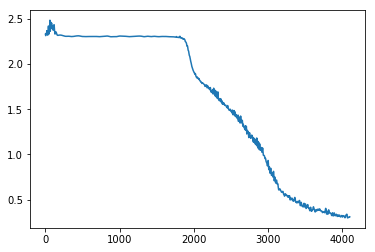

In [5]:
Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
# dnn = DNN([1000, 750, 500])
# dnn.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=3)
# vs
dnn = DNN([1000, 750, 500])
dnn.fit(Xtrain, Ytrain, Xtest, Ytest, pretrain=False, epochs=10)

training autoencoder: 0
epoch: 0
j / n_batches: 0 / 410 cost: 0.6883044225436457
j / n_batches: 10 / 410 cost: 0.4059664534751598
j / n_batches: 20 / 410 cost: 0.28288249426887885
j / n_batches: 30 / 410 cost: 0.27139981051514794
j / n_batches: 40 / 410 cost: 0.25171069729626827
j / n_batches: 50 / 410 cost: 0.256481239768268
j / n_batches: 60 / 410 cost: 0.2546982448558996
j / n_batches: 70 / 410 cost: 0.2557233150824844
j / n_batches: 80 / 410 cost: 0.24588422454641298
j / n_batches: 90 / 410 cost: 0.23614306304601923
j / n_batches: 100 / 410 cost: 0.22656118840664333
j / n_batches: 110 / 410 cost: 0.21898584466620458
j / n_batches: 120 / 410 cost: 0.2134861245719493
j / n_batches: 130 / 410 cost: 0.20476284135133135
j / n_batches: 140 / 410 cost: 0.19433274589601715
j / n_batches: 150 / 410 cost: 0.20566336037908248
j / n_batches: 160 / 410 cost: 0.19358162012035407
j / n_batches: 170 / 410 cost: 0.1828608014446448
j / n_batches: 180 / 410 cost: 0.1804878822041776
j / n_batches: 190

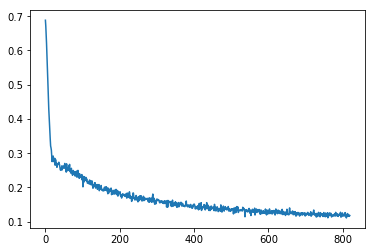

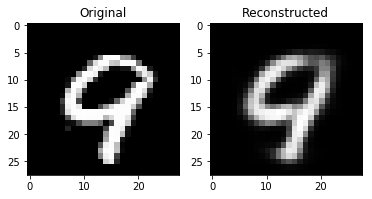

Generate another?n


In [6]:
# test_single_autoencoder
Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()

autoencoder = AutoEncoder(300, 0)
autoencoder.fit(Xtrain, epochs=2, show_fig=True)

done = False
while not done:
    i = np.random.choice(len(Xtest))
    x = Xtest[i]
    y = autoencoder.predict([x])
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28,28), cmap='gray')
    plt.title('Original')

    plt.subplot(1,2,2)
    plt.imshow(y.reshape(28,28), cmap='gray')
    plt.title('Reconstructed')

    plt.show()

    ans = input("Generate another?")
    if ans and ans[0] in ('n' or 'N'):
        done = True
